In [1]:

import arviz as az
import pymc as pm
import preliz as pz
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as ipyw
from IPython.display import IFrame
import seaborn as sns

# Sampling diagnosis
## Revisiting Bayes' theorem

$$p(\theta|y) = \frac{p(y|\theta)p(\theta)}{p(y)}$$
- The calculation of the posterior is hard because of the marginal likelihood, $p(y)$, defined as $$p(y) = \int_{\Theta} p(y|\theta)p(\theta)d\theta$$
- The integral will have as many parameters as there are in the model
- Integrals in large dimensions are hard to solve
- Easy when we have conjugate priors, but its not always the case

## Calculating posterior

### Grid method
- Simplest approach
- Algorithm
  - Find a reasonable range of parameters
  - Define a grid of points
  - For each grid point, evaluate the prior and the likelihood at that point and multiply
- Can be useful, but it doesnt scale to many dimensions

In [2]:
def grid_posterior(grids=10,a=1,b=1,heads=6,trials=9):
    
    grid = np.linspace(0,1,grids) #thetas
    prior = pz.Beta(a,b).rv_frozen.pdf(grid)
    likelihood = pz.Binomial(n=trials,p=grid).rv_frozen.pmf(heads) ## How likely is the data given the parameters
    posterior = likelihood * prior
    posterior = posterior / posterior.sum()
    _, ax = plt.subplots(1, 3, sharex=True, figsize=(12, 3))
    ax[0].set_title(f'heads = {heads}\n trials = {trials}')
    for i, (e, e_n) in enumerate(zip([prior, likelihood, posterior], ['a priori', 'likelihood', 'a posteriori'])):
        ax[i].set_yticks([])
        ax[i].plot(grid, e, 'o-', label=e_n)
        ax[i].legend() 

In [3]:
interact(grid_posterior, grilla=ipyw.IntSlider(min=2, max=100, step=1, value=15), a=ipyw.FloatSlider(min=1, max=7, step=1, value=1), b=ipyw.FloatSlider(
    min=1, max=7, step=1, value=1), heads=ipyw.IntSlider(min=0, max=20, step=1, value=6), trials=ipyw.IntSlider(min=0, max=20, step=1, value=9));

interactive(children=(IntSlider(value=10, description='grids', max=30, min=-10), FloatSlider(value=1.0, descri…

### MCMC
- Evaluations that focus on high probability regions
- Eventually, the method will return samples proportional to the posterior probability
- Algorithm
  - Generate a new point from a pre-existing one
  - Accept or reject that point probabilistic and comparing the probability of the pre-existing point and the new point

### Metropolis-Hasting
1. Initialize the parameter X in $x_{i}$
2. Use proposal distribution $q(x_{i+1}|x_{i})$ to generate new value $x_{i+1}$
3. Calculate the probability of accepting new value as $$p_{a}(x_{i+1}|x_{i}) = min(1,\frac{p(x_{i+1})q(x_{i}|x_{i+1})}{p(x_{i})q(x_{i+1}|x_{i})})$$
4. If $p_{a} > R$, where $R \sim U(0,1)$, save the new value, otherwise, save the previous one
5. Iterate from 2 to 4 until a large enough sample has been generated
- $p(x_{i})$ is the density of the posterior evaluated at the parameter value $x_{i}$. 

In [4]:
# Solving for the beta-binomial model
def posterior(theta,Y,alpha,beta):
    if 0 <= theta <= 1:
        prior = stats.beta(alpha,beta).pdf(theta)
        like = stats.bernoulli(theta).pmf(Y).prod()
        prob = like * prior
    else:
        prob = -np.inf
    return prob
Y = stats.bernoulli(0.7).rvs(20)
n_iters = 10000
can_sd = 0.05
alpha = beta = 1
theta = 0.5
trace = {"theta":np.zeros(n_iters)}
p2 = posterior(theta,Y,alpha,beta)
for iter in range(n_iters):
    theta_can = stats.norm(theta, can_sd).rvs(1)# Sample new proposal value
    p1 = posterior(theta_can,Y,alpha,beta) # Compute the posterior using it
    pa = p1 / p2 # Computes the ratio. If q is invertible, qs cancelates
    if pa > stats.uniform(0,1).rvs(1): # If pa is greater than the value sampled from the uniform(0,1)
        theta = theta_can # Becomes new theta
        p2 = p1 # Updates the current posterior
    trace["theta"][iter] = theta    

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_15108\2193289943.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trace["theta"][iter] = theta


c:\Users\Gabriel\mambaforge\envs\bayes\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Gabriel\mambaforge\envs\bayes\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

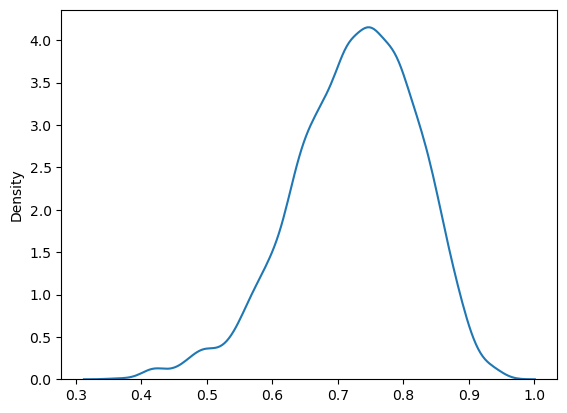

In [5]:
sns.kdeplot(trace['theta'])

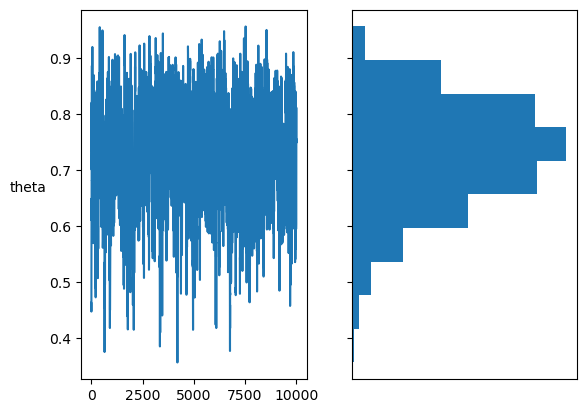

In [6]:
_, axes = plt.subplots(1,2, sharey=True)
axes[0].plot(trace['theta'])
axes[0].set_ylabel('theta', rotation=0, labelpad=15)
axes[1].hist(trace['theta'], orientation="horizontal", density=True)
axes[1].set_xticks([]);

### Hamiltonian Monte Carlo
- Hamiltonian: Total energy of a physical system $$H(q,p) = K(p,q) + V(q)$$ where
  - V: Potencial energy
  - K: Kinetic energy
  - q: Parameters the probabilistic model can take
  - Potencial energy is the posterior probability of those values q
- HMC has two steps:
  - Generate a new point from the Hamiltonian
  - Accept or reject that point probabilistically and comparing the probability of the pre-existing point to the new point
- Divergences: Unstable simulation
- When parameters are correct, HMC is much more efficient than MC
- NUTS: No U-Turn Sampler
  - Parameters are calculated adaptively by running a number of HMC steps which are used to adjust those hyper-parameters automatically and then discared
  - Default sampler in PyMC

## General diagnostics
- Assymptotically the MCMCs offer the correct answer
- Diagnostic method to check if sampling is correct for finite samples
- Theory:
  - Initial value is irrevalant, must always converge to the same
  - Samples are not really independent, but the value of a point depends only on the last one, no long term correlations
- Trace plots
  - Plot iteration(x) vs value
  - Should se only noise, not patterns
  - az.plot_trace()
- Rank plots
  - For a paramameter, take all the chains and order the values from lowest to highest and assign them a range (smallest = 0, then 1) untill reach the total number of samples(chains * samples per chain)
  - Regroup the rankings according to chain and for each chain plot a histogram
  - If chains are indistinguishable -> Expect the histograms to be uniform
  - az.plot_rank()
- $\hat{R}$
  - Compares variance between chains with the variance inside each chain
  - Ideally, $\hat{R} = 1$
  - az.rhat(), az.summary(),az.plot_forest(.,r_hat=True)
- Autocorrelation plot
  - Sample should be *iid*, but MCMC samples are correlated. We want samples with low autocorrelation
  - az.plot_autocorr()
- Effective Sample Size (ESS):
  - The size of a sample with the equivalent ammount of information but without autocorrelation
  - Recommend that the ESS be greather than 100 per chain. So, with 4 chains, minimum of 400.
  - az.ess(⋅), az.summary(⋅) and az.plot_forest(⋅, ess=True)
  - ess_bulk: Assure that is something enough if we want to calculate central values (median,mean)
  - ess_tail: Assure that is adequate if we want to calculate intervals like 95% HDI
- Monte Carlo Standard Error (MCSE)
  - Error made when aproximating posterior
  - Takes into account the autocorrelation of samples
  - Should be below the desired precision
  - If the MCSE is 0.1 and the mean is 3.15, it doesnt make sense to report it, since the correct value could be between 3.4 and 2.8

## Diagnosis of gradient-based algorithms
- Two models, parametrized in different ways
  - It affects sample efficiency
- Transitional Energy vs Marginal Energy
  - If both are similar, then NUTS is able to generate samples of the marginal energy distribution that are almost independent between transitions
- Divergences
  - Go from regions of low curvature to high curvature

In [7]:
idata_cm = az.load_arviz_data("centered_eight")
idata_ncm = az.load_arviz_data("non_centered_eight")

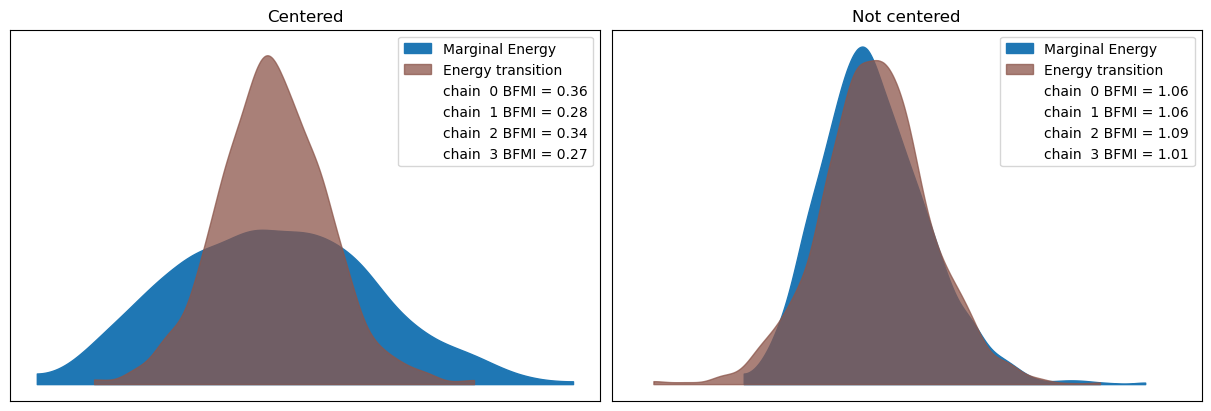

In [10]:
_, axes = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 4), constrained_layout=True)

for ax, idata, name in zip(axes.ravel(), (idata_cm, idata_ncm), ("Centered", "Not centered")):
    az.plot_energy(idata, ax=ax)
    ax.set_title(name)

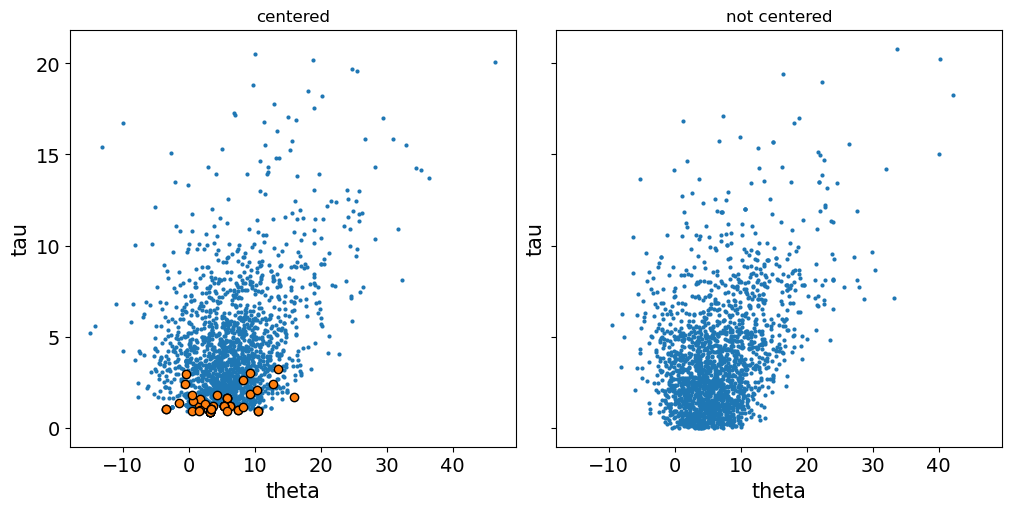

In [11]:
_, axes = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10, 5), constrained_layout=True)


for ax, idata, name in zip(axes.ravel(), (idata_cm, idata_ncm), ("centered", "not centered")):
    az.plot_pair(idata, var_names=['theta', 'tau'], coords={'school':"Choate"}, kind='scatter',
                 divergences=True, divergences_kwargs={'color':'C1'},
                 ax=ax)
    ax.set_title(name)

## What to do when the diagnoses are wrong?
- More samples or more tuning steps
- Burn in(number of samples to tune hyperparameters)
- Change the sampling method
- Reparametrize the model(centered->Not centered)
- Improvide prior distributions
  - If the sampling is bad, probably the model is the problem
- Increasing acceptance rate (**pm.sample(...,sample_target=x)**), $ x > 0.8$